In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler


In [3]:
class LogisticsDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.features = data.drop(columns=['emission_class'])
        # Input features
        self.features = data[
            ['source', 'source_country','destination','destination_country','transportation_mode','distance','emission']
        ]
        # Mode as target
        self.mode = data['transportation_mode']
        self.emission_class = data['emission_class'].values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        features = torch.tensor(self.features.iloc[idx].values, dtype=torch.float32)
        mode = torch.tensor(self.mode.iloc[idx], dtype=torch.long)
        eclass = torch.tensor(self.emission_class[idx], dtype=torch.long)
        return features, mode, eclass


In [8]:
# Load the dataset
import joblib
data = pd.read_excel('data/cleaned/supply_chain_data.xlsx')

# Preprocessing
label_encoders = {}
# Encoding categorical features
categorical_columns = ['source', 'source_country','destination','destination_country', 'transportation_mode' ]
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le
    encoders_path = "data/cleaned/"
    joblib.dump(le, f"{encoders_path}{col}_label_encoder.pkl")


# Scale high-cardinality categorical columns into [0,1]
for col in ['source', 'destination']:
    data[col] = data[col] / data[col].max()

# scale others if they have many values
for col in ['source_country', 'destination_country']:
    data[col] = data[col] / data[col].max()
# Standardize numerical features
scaler = StandardScaler()
data[['distance', 'emission']] = scaler.fit_transform(data[['distance', 'emission']])

# Create emission classes (0=low, 1=medium, 2=high)
data['emission_class'] = pd.qcut(data['emission'], q=3, labels=[0, 1, 2]).astype(int)
# Map column names to indices
feature_index_map = {col: idx for idx, col in enumerate(data.columns)}

# Save for easy access
EMISSION_IDX = feature_index_map['emission']
DISTANCE_IDX = feature_index_map['distance']
# Split the data into training and test datasets
train_data = data.sample(frac=0.9, random_state=42)
test_data = data.drop(train_data.index)

# Convert data into Dataset objects
train_dataset = LogisticsDataset(train_data)
test_dataset = LogisticsDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # <== smaller batch size
test_loader = DataLoader(test_dataset, batch_size=16)


In [3]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_modes, num_conditions=3, cond_emb_dim=8):
        super().__init__()
        self.latent_dim = latent_dim
        self.cond_emb = nn.Embedding(num_conditions, cond_emb_dim)

        encoder_input_dim = input_dim + cond_emb_dim
        decoder_input_dim = latent_dim + cond_emb_dim

        self.encoder = nn.Sequential(
            nn.Linear(encoder_input_dim, 128),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(decoder_input_dim, 128),
            nn.ReLU(),
        )
        self.recon_out = nn.Linear(128, input_dim)
        self.mode_out = nn.Linear(128, num_modes)

    def encode(self, x, cond):
        cond_emb = self.cond_emb(cond)
        x_cat = torch.cat([x, cond_emb], dim=1)
        h = self.encoder(x_cat)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, cond):
        cond_emb = self.cond_emb(cond)
        z_cat = torch.cat([z, cond_emb], dim=1)
        h = self.decoder(z_cat)
        return self.recon_out(h), self.mode_out(h)

    def forward(self, x, cond):
        mu, logvar = self.encode(x, cond)
        z = self.reparameterize(mu, logvar)
        recon_x, mode_logits = self.decode(z, cond)
        return recon_x, mode_logits, mu, logvar


In [11]:
def loss_function_with_emission(
    recon_x, mode_prob, x, mu, logvar, mode_target, emission_weight, mode_weight=1.0
):
    # Extract only distance and emission from recon_x and x
    recon_continuous = recon_x[:, -2:]  # assuming last 2 features are distance & emission
    target_continuous = x[:, -2:]

    # Full reconstruction loss (distance + emission)
    mse_recon = torch.sum((recon_continuous - target_continuous) ** 2)

    # Emission-specific loss (for monitoring)
    emission_mse = torch.sum((recon_continuous[:, 1] - target_continuous[:, 1]) ** 2)

    # Mode classification loss
    mode_loss = nn.functional.cross_entropy(mode_prob, mode_target)

    # KL Divergence
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    total_loss = (
        mse_recon
        + emission_weight * emission_mse
        + mode_weight * mode_loss
        + 0.001 * kl_div
    )

    return total_loss, emission_mse.item(), kl_div.item()



In [13]:
# VAE parameters
input_dim = 7
latent_dim = 4
number_of_modes = len(data['transportation_mode'].unique())
emission_weight = 20
patience = 15
best_loss = float("inf")
epochs_no_improve = 0
epochs = 200

# Logs
train_losses = []
test_losses = []
kl_divergences = []
emission_losses = []
emission_test_losses = []

# Model
model = VAE(input_dim, latent_dim=latent_dim, num_modes=number_of_modes, num_conditions=3)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# LR scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5)

# Training Loop
for epoch in range(epochs):
    model.train()
    train_loss = 0

    for data_batch, mode_batch, cond in train_loader:
        optimizer.zero_grad()

        recon_x, mode_prob, mu, logvar = model(data_batch, cond)

        loss, emission_loss, kl_div = loss_function_with_emission(
            recon_x, mode_prob, data_batch, mu, logvar, mode_batch, emission_weight=emission_weight
        )

        emission_losses.append(emission_loss)
        kl_divergences.append(kl_div)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for data_batch, mode_batch, cond in test_loader:
            recon_x, mode_prob, mu, logvar = model(data_batch, cond)
            loss, emission_loss_test, _ = loss_function_with_emission(
                recon_x, mode_prob, data_batch, mu, logvar, mode_batch, emission_weight=emission_weight
            )
            test_loss += loss.item()
            emission_test_losses.append(emission_loss_test)

    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f}")

    # Early stopping
    if avg_test_loss < best_loss:
        best_loss = avg_test_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "models/best_model.pt")
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print("Early stopping triggered.")
        break

    scheduler.step(avg_test_loss)



Epoch 1/200 | Train Loss: 284.3058 | Test Loss: 150.6400
Epoch 2/200 | Train Loss: 69.1448 | Test Loss: 11.0604
Epoch 3/200 | Train Loss: 7.0773 | Test Loss: 3.1861
Epoch 4/200 | Train Loss: 2.0175 | Test Loss: 1.3384
Epoch 5/200 | Train Loss: 1.0243 | Test Loss: 0.8770
Epoch 6/200 | Train Loss: 0.7807 | Test Loss: 0.7724
Epoch 7/200 | Train Loss: 0.6613 | Test Loss: 0.6491
Epoch 8/200 | Train Loss: 0.6053 | Test Loss: 0.5989
Epoch 9/200 | Train Loss: 0.5541 | Test Loss: 0.5669
Epoch 10/200 | Train Loss: 0.5185 | Test Loss: 0.5185
Epoch 11/200 | Train Loss: 0.4867 | Test Loss: 0.4749
Epoch 12/200 | Train Loss: 0.4659 | Test Loss: 0.4729
Epoch 13/200 | Train Loss: 0.4440 | Test Loss: 0.4517
Epoch 14/200 | Train Loss: 0.4273 | Test Loss: 0.4163
Epoch 15/200 | Train Loss: 0.4118 | Test Loss: 0.4311
Epoch 16/200 | Train Loss: 0.3985 | Test Loss: 0.3968
Epoch 17/200 | Train Loss: 0.3881 | Test Loss: 0.3782
Epoch 18/200 | Train Loss: 0.3763 | Test Loss: 0.3714
Epoch 19/200 | Train Loss: 0.36

In [14]:
train_data.shape

(6522, 8)

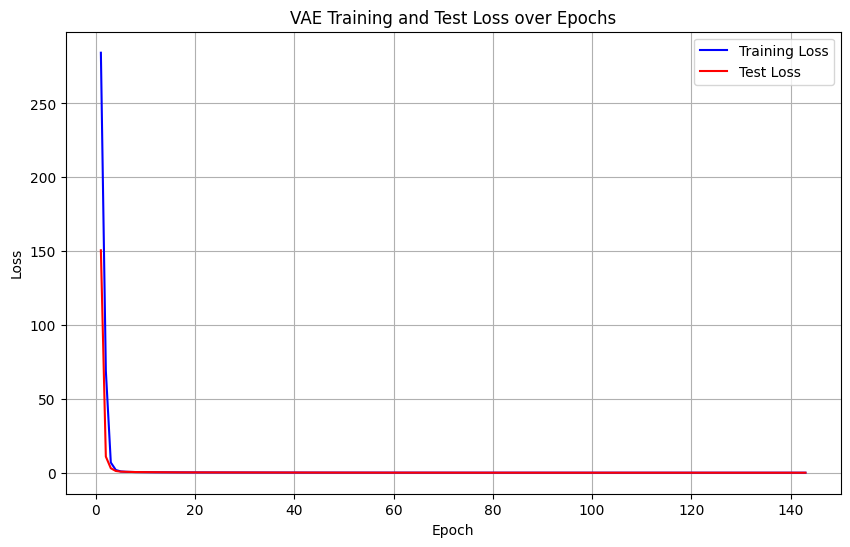

In [15]:
from matplotlib import pyplot as plt

# Use the actual length of recorded losses
epochs_run = len(train_losses)

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs_run + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, epochs_run + 1), test_losses, label='Test Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Training and Test Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()



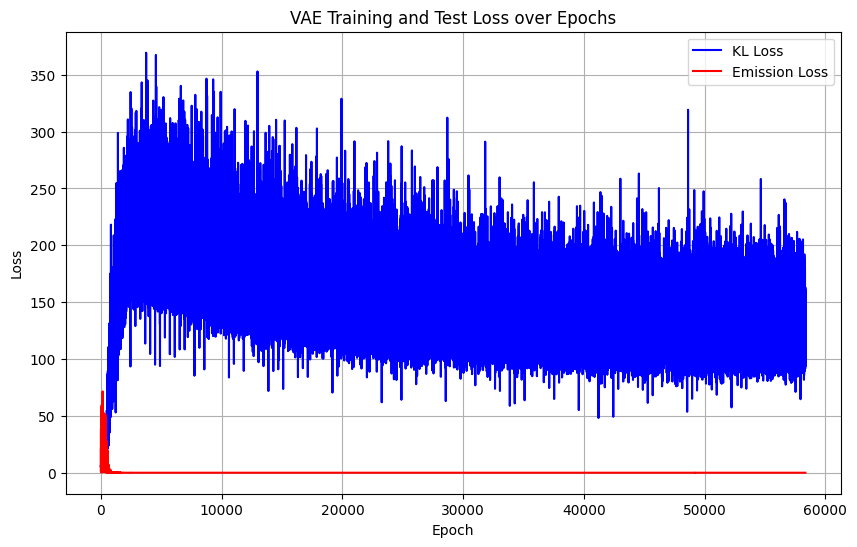

In [16]:
from matplotlib import pyplot as plt

# Use the actual length of recorded losses
epochs_run = len(train_losses)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(kl_divergences)+1), kl_divergences, label='KL Loss', color='blue')
plt.plot(range(1, len(emission_losses)+1), emission_losses, label='Emission Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Training and Test Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

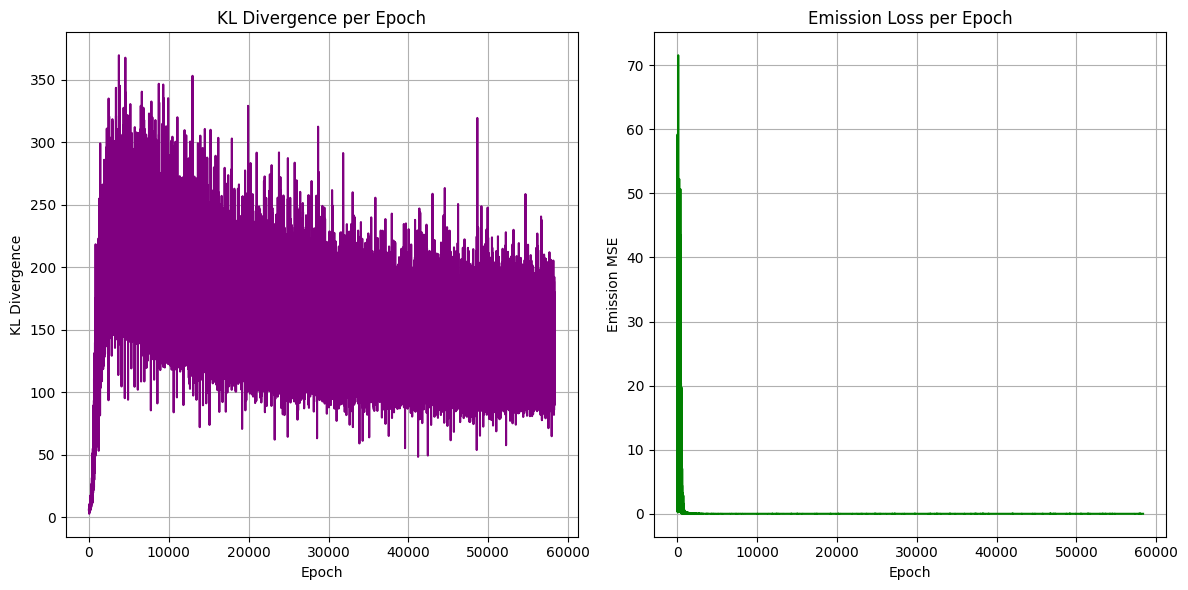

In [17]:
plt.figure(figsize=(12, 6))

# Plot KL divergence
plt.subplot(1, 2, 1)
plt.plot(range(1, len(kl_divergences)+1), kl_divergences, color='purple')
plt.title('KL Divergence per Epoch')
plt.xlabel('Epoch')
plt.ylabel('KL Divergence')
plt.grid(True)

# Plot emission-specific loss
plt.subplot(1, 2, 2)
plt.plot(range(1, len(emission_losses)+1), emission_losses, color='green')
plt.title('Emission Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Emission MSE')
plt.grid(True)

plt.tight_layout()
plt.savefig("vae_loss_plot.png", dpi=300, bbox_inches='tight')
plt.show()


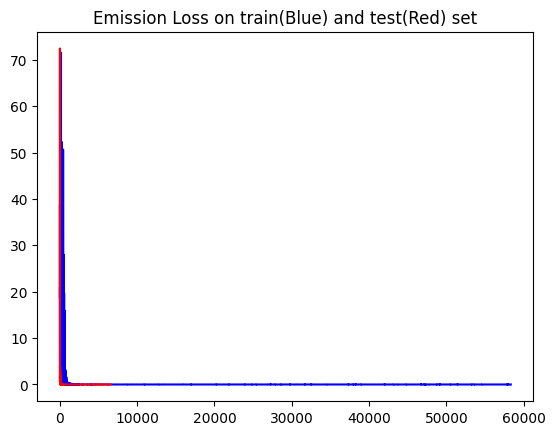

In [18]:
plt.plot(emission_losses, label="Train Emission Loss", color='blue')
plt.plot(emission_test_losses, label="Test Emission Loss", color='red')
plt.title('Emission Loss on train(Blue) and test(Red) set')
plt.savefig("vae_loss_plot1.png", dpi=300, bbox_inches='tight')
plt.show()

In [22]:
torch.save(model.state_dict(), "best_model.pt")

In [21]:
import torch
import pandas as pd
import numpy as np

# Load best model
model.load_state_dict(torch.load("models/best_model.pt"))
model.eval()

num_samples = 6500
desired_emission_class = 0  # 0 = low, 1 = medium, 2 = high

with torch.no_grad():
    # Sample latent vectors
    z = torch.randn(num_samples, latent_dim)

    # Create condition tensor
    cond = torch.full((num_samples,), desired_emission_class, dtype=torch.long)

    # Decode
    recon_x, mode_logits = model.decode(z, cond)
    recon_x = recon_x.cpu().numpy()
    mode_pred = torch.argmax(mode_logits, dim=1).cpu().numpy()

    # Reconstruct column names and indices
    reconstructed_df = pd.DataFrame(recon_x, columns=data.columns[:recon_x.shape[1]])
    reconstructed_df['transportation_mode'] = mode_pred

    # Inverse scaling: restore original distance and emission
    reconstructed_df[['distance', 'emission']] = scaler.inverse_transform(
        reconstructed_df[['distance', 'emission']]
    )

    # Inverse label encoding for categorical columns
    for col in categorical_columns:
        if col != 'transportation_mode':  # already replaced
            le = label_encoders[col]
            col_values = reconstructed_df[col].round().astype(int).clip(0, len(le.classes_) - 1)
            reconstructed_df[col] = le.inverse_transform(col_values)

    # Map back transportation_mode
    le_mode = label_encoders['transportation_mode']
    reconstructed_df['transportation_mode'] = le_mode.inverse_transform(
        reconstructed_df['transportation_mode'].clip(0, len(le_mode.classes_) - 1)
    )

    print("Generated Routes (Conditioned on Low Emission):")
    #print(reconstructed_df)
    print("\nAverage Emission (Generated):", reconstructed_df['emission'].mean())

    # train data original
    # Extract the scaled emission column
    scaled_emission = data['emission'].values.reshape(-1, 1)
    # Apply inverse transform
    original_emission_train = scaler.inverse_transform(np.hstack([np.zeros_like(scaled_emission), scaled_emission]))[:, 1]
    # Compute mean
    print("Average Emission (data - Original):", np.mean(original_emission_train))


Generated Routes (Conditioned on Low Emission):

Average Emission (Generated): 106.21856
Average Emission (data - Original): 549.7319472381581


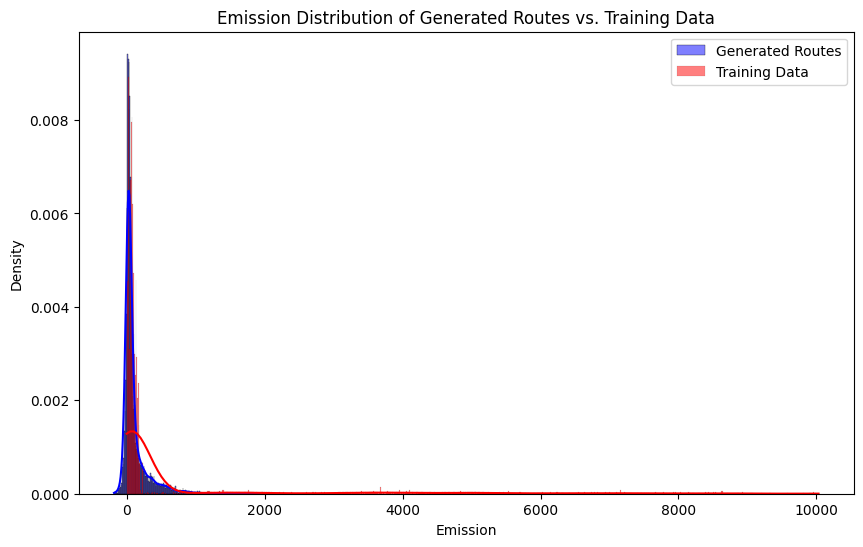

In [36]:
# Visual Inspection of Emission Distribution
# We can visualize the emission distribution of both the original and generated routes using histograms and KDE plots.
# Visualize the emission distribution of original vs generated routes
import seaborn as sns

generated_emissions = reconstructed_df['emission']
original_emissions = original_emission_train

def plot_emission_distribution(original_emissions, generated_emissions):
    plt.figure(figsize=(10, 6))
    sns.histplot(generated_emissions, kde=True, color='blue', label='Generated Routes', stat='density')
    sns.histplot(original_emissions, kde=True, color='red', label='Training Data', stat='density')
    plt.xlabel('Emission')
    plt.ylabel('Density')
    plt.title('Emission Distribution of Generated Routes vs. Training Data')
    plt.legend()
    plt.show()

# Plot the distribution
plot_emission_distribution(original_emissions, generated_emissions)

In [38]:
# Emission Reduction (Average Emission and Percentage Emission Reduction)
# Now, let's calculate how much the generated routes reduce emissions compared to the original routes.
# Calculate average emission reduction
def emission_reduction(original_emissions, generated_emissions):
    avg_original = np.mean(original_emissions)
    avg_generated = np.mean(generated_emissions)

    reduction = avg_original - avg_generated
    percentage_reduction = (reduction / avg_original) * 100

    return reduction, percentage_reduction

# Assuming generated_routes_df contains the generated routes' emissions and `data` contains the original data
generated_emissions = reconstructed_df['emission'].values
training_emissions = original_emissions

# Calculate emission reduction
emission_reduction_value, percentage_emission_reduction = emission_reduction(training_emissions, generated_emissions)

print(f"Average Emission Reduction: {emission_reduction_value:.4f}")
print(f"Percentage Emission Reduction: {percentage_emission_reduction:.2f}%")

Average Emission Reduction: 443.5134
Percentage Emission Reduction: 80.68%


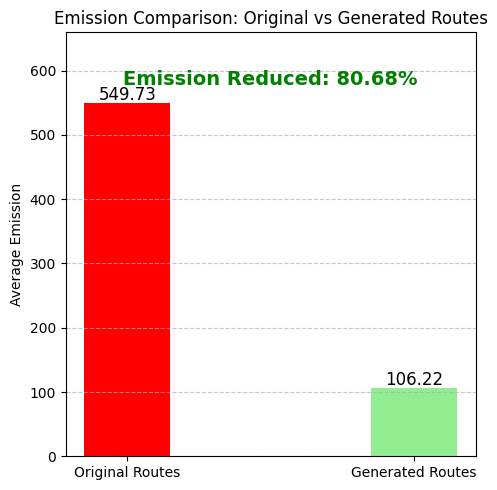

In [47]:
# Compute means again just in case
avg_original = np.mean(training_emissions)
avg_generated = np.mean(generated_emissions)
reduction = avg_original - avg_generated
percentage_reduction = (reduction / avg_original) * 100

# Plot
labels = ['Original Routes', 'Generated Routes']
values = [avg_original, avg_generated]

plt.figure(figsize=(5, 5))
bars = plt.bar(labels, values, color=['red', 'lightgreen'],width=0.3)
plt.ylabel("Average Emission")
plt.title("Emission Comparison: Original vs Generated Routes")

# Annotate bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, f'{yval:.2f}', ha='center', fontsize=12)

# Annotate percentage reduction
plt.text(0.5, max(values) * 1.05, f'Emission Reduced: {percentage_reduction:.2f}%',
         ha='center', fontsize=14, fontweight='bold', color='green')

plt.ylim(0, max(values) * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

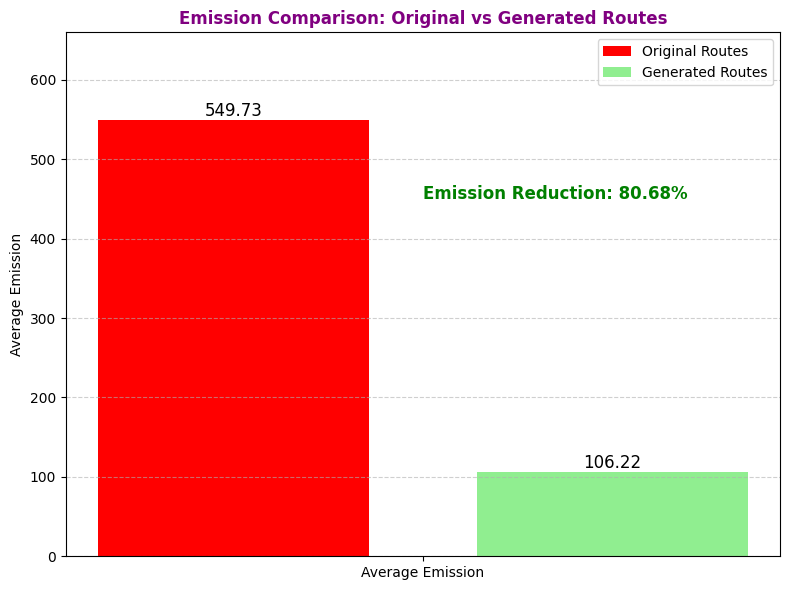

In [71]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
categories = ['Average Emission']
original_vals = [avg_original]
generated_vals = [avg_generated]
reduction = avg_original - avg_generated
percentage_reduction = (reduction / avg_original) * 100
x = np.arange(len(categories))  # [0, 1, ...]
bar_width = 0.35  # Narrower bars for grouped effect

# Plot
plt.figure(figsize=(8, 6))
plt.bar(x - bar_width/2, original_vals, width=0.25, label='Original Routes', color='Red')
plt.bar(x + bar_width/2, generated_vals, width=0.25, label='Generated Routes', color='lightgreen')

# Annotations
for i in range(len(categories)):
    plt.text(x[i] - bar_width/2, original_vals[i] + 5, f'{original_vals[i]:.2f}', ha='center', fontsize=12)
    plt.text(x[i] + bar_width/2, generated_vals[i] + 5, f'{generated_vals[i]:.2f}', ha='center', fontsize=12)

# X-axis setup
plt.xticks(x, categories)
plt.ylabel("Average Emission")
plt.title(f"Emission Comparison: Original vs Generated Routes",color="purple",fontweight='bold')
plt.text(0, 450, f'Emission Reduction: {percentage_reduction:.2f}%',
         ha='left', fontsize=12, fontweight='bold', color='green')
plt.ylim(0, max(original_vals + generated_vals) * 1.2)

plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [86]:
def predict_best_transportation_mode_and_low_emission_route(
    model,
    new_route_info,
    label_encoders,
    scaler,
    emission_class=0,  # 0 = low
    emission_weight=10
):
    """
    Predict the best transportation mode and low-emission route for new input using a trained VAE.

    :param model: Trained conditional VAE model.
    :param new_route_info: A dictionary containing raw input features.
    :param label_encoders: Dictionary of fitted label encoders.
    :param scaler: Trained StandardScaler used for distance and emission.
    :param emission_class: Target condition (0 = low emission, 1 = medium, 2 = high).
    :return: predicted distance, predicted emission, best mode
    """
    model.eval()

    # Step 1: Encode categorical variables
    encoded_input = new_route_info.copy()
    for col in ['source', 'source_country', 'destination', 'destination_country', 'transportation_mode']:
        le = label_encoders[col]
        val = encoded_input[col]
        # encoded_input[col] = le.transform([encoded_input[col]])[0]
        if val in le.classes_:
            encoded_input[col] = le.transform([val])[0]
        else:
        # fallback: use a special value (e.g., -1 or a reserved index)
            encoded_input[col] = -1

    # Step 2: Scale high-cardinality categorical vars (if used in training)
    for col in ['source', 'destination', 'source_country', 'destination_country']:
        encoded_input[col] = encoded_input[col] / label_encoders[col].classes_.shape[0]

    # Step 3: Standardize distance (no emission yet)
    distance_scaled = scaler.transform([[encoded_input['distance'], 0]])[0][0]
    encoded_input['distance'] = distance_scaled
    #encoded_input['distance'] = 0.0
    encoded_input['emission'] = 0.0  # dummy

    # Step 4: Convert input dict to tensor
    feature_tensor = torch.tensor([list(encoded_input.values())], dtype=torch.float32)
    cond_tensor = torch.tensor([emission_class], dtype=torch.long)

    # Step 5: Forward pass
    with torch.no_grad():
        mu, logvar = model.encode(feature_tensor, cond_tensor)
        #z = model.reparameterize(mu, logvar) # for diverse output
        z = mu
        recon_x, mode_logits = model.decode(z, cond_tensor)

        # Inverse transform
        recon_np = recon_x.numpy()[0]
        distance_pred = scaler.inverse_transform([[recon_np[-2], 0]])[0][0]
        emission_pred = scaler.inverse_transform([[0, recon_np[-1]]])[0][1]

        mode_pred = mode_logits.argmax(dim=1).item()

    return distance_pred, emission_pred, mode_pred


In [87]:

new_route_info = {
    'source': 'Madrid',
    'source_country': 'Spain',
    'destination': 'Istanbul',
    'destination_country': 'Turkey',
    'transportation_mode': 'Air Freight',
    'distance': 3500
}

distance, emission, best_mode = predict_best_transportation_mode_and_low_emission_route(
    model=model,
    new_route_info=new_route_info,
    label_encoders=label_encoders,
    scaler=scaler,
    emission_class=0  # condition on "low emission"
)

print("Predicted Distance:", distance)
print("Predicted Emission:", emission)
print("Best Mode Index:", best_mode)
print("Mode Label:", label_encoders['transportation_mode'].inverse_transform([best_mode])[0])


Predicted Distance: 2855.6191951789056
Predicted Emission: 295.59918669330864
Best Mode Index: 1
Mode Label: Cargo Train


/Users/sajanakadangara/code_base/research_project/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [9]:
## Inference on Test samples

In [10]:
def get_prediction_vae(src, src_country, dest, dest_country, distance, transport_mode):

    route_info = {}
    route_info['source'] = src
    route_info['source_country'] = src_country
    route_info['destination'] = dest
    route_info['destination_country'] = dest_country
    route_info['distance'] = distance
    route_info['transportation_mode'] = transport_mode

    pred_distance, emission, best_mode = predict_best_transportation_mode_and_low_emission_route(
    model=model,
    new_route_info=route_info,
    label_encoders=label_encoders,
    scaler=scaler,
    emission_class=0  # condition on "low emission"
    )

    predicted_info = {}
    predicted_info['distance'] = pred_distance
    predicted_info['emission'] = emission
    predicted_info['transportation_mode'] = best_mode

    return predicted_info

In [ ]:
test_df = pd.read_excel("data/cleaned/data_eval.xlsx")

In [ ]:
test_df.head()

In [ ]:
test_df['vae_output'] = test_df.apply(lambda x: get_prediction_vae(x['source'],
                                                x['source_country'], x['destination'],
                                                x['destination_country'],x['distance'],
                                                x['transportation_mode']),axis=1)

In [ ]:
test_df.to_excel("results/vae_outputs/test_result_VAE_output.xlsx", index=False)